#### Mounting the Google Drive


In [1]:
# # from google.colab import drive
# drive.mount('/content/drive') #https://drive.google.com/drive/folders/1k5mg7P5c_vfvFZ42cYVP66ZhZ5PpOB2z?usp=drive_link

In [2]:
# ! install cv2

## Data Loading



In [3]:
# ! pip install keras

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
from skimage import color, io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# set the matplotlib backend so figures can be saved in the background
import matplotlib
import tensorflow as tf
from tqdm import tqdm
#matplotlib.use("Agg")
# import the necessary packages
#from pyimagesearch.resnet import ResNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import img_to_array
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
from skimage import color, io
from tensorflow.keras import layers, Model, utils
from skimage import color, io
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from io import BytesIO
import time
from imutils import paths
import shutil
import itertools
import pandas as pd
from IPython.display import Image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
#from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Activation, Dense, Flatten, RepeatVector, Dropout,GlobalAveragePooling2D,GlobalMaxPooling2D

## **Downloading the dataset**

## **Define Parameters**

Define required parameters for the implementation. This includes,


1.   `BASE_PATH:` google drive base path to the project.
2.   `DATASET_PATH:` path in google drive to the dataset (Both small and large datasets: https://drive.google.com/drive/folders/1ew5AMnyhpRP9OcLRH49Wd1Y3h3btNW_Q?usp=sharing).


> Make sure you replace the dataset with the images in the given link (naming format is important => Deforestation_(image number).jpg. *Labeled dataset is not required.



3. `SHAPE`: shape of the images required for the CNN architecture (299,299,3).

Folder structure: Drive => Colab Notebooks => FYP - Anomaly Detection in Image Streams => datasets =>
  1. Large_Dataset
  2. Small_Dataset
  => Unabeled
  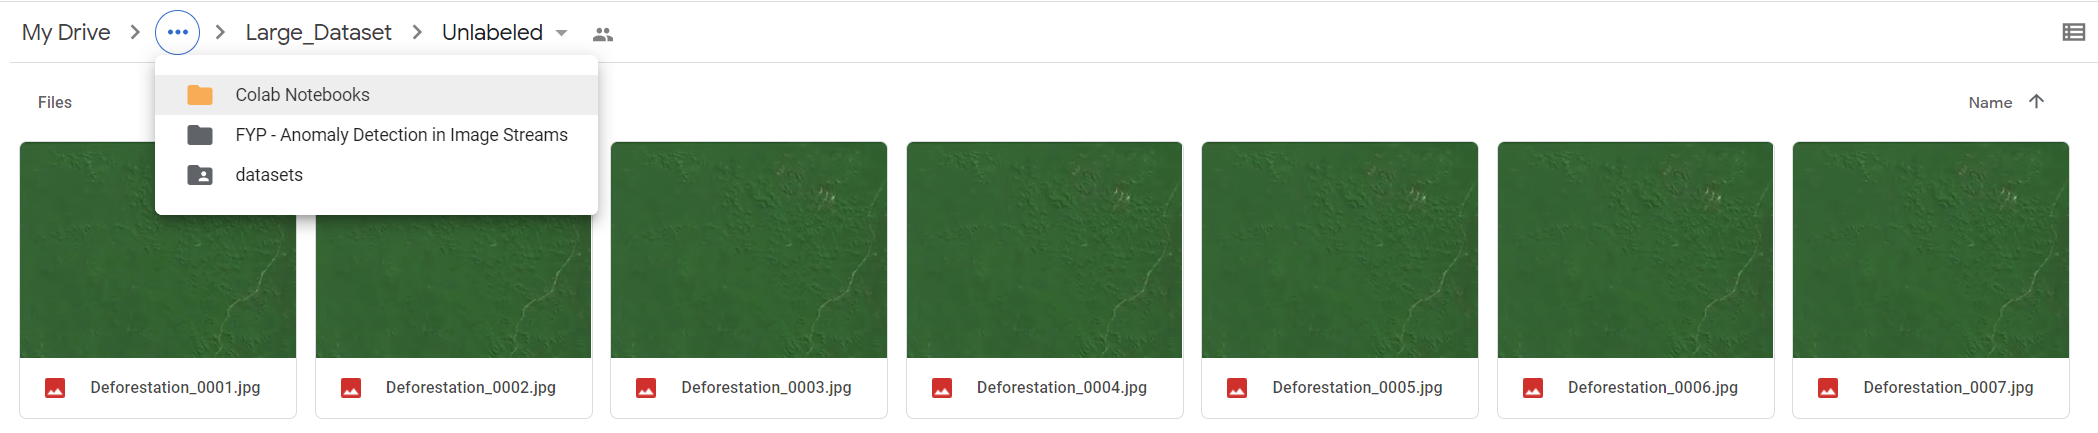




In [5]:
BASE_PATH = "C:/nethmee/Inception/content/drive/MyDrive/Colab Notebooks/FYP - Anomaly Detection in Image Streams"
DATASET_PATH = BASE_PATH + "/datasets"

#Initialize the path to the original input directory of images
ORIG_LARGE_INPUT_DATASET = DATASET_PATH + "/Large_Dataset"
ORIG_SMALL_INPUT_DATASET = DATASET_PATH + "/Small_Dataset"

#Initialize paths to load the predictions of the Deep Learning (Resnet50+LSTM) module for Large Dataset
DEEP_LEARNING_MODULE_OUTPUTS_FOR_LARGE_DATASET = BASE_PATH + "/predictions/inceptionV3"

#Initialize paths to save extracted features
RESNET_FEATURES = BASE_PATH + "/ResNet50Features"

#Initialize paths to save the XAI SHAP results
SHAP_RESULTS = BASE_PATH + "/XAI_results/inceptionV3/shap"
#Initialize paths to save the XAI LIME results
LIME_RESULTS = BASE_PATH + "/XAI_results/inceptionV3/lime"

#Define names of the training, testing and validation directories
TRAIN = "training"
VAL = "validation"
TEST = "evaluation"

#Define shape
img_width = 299
img_height = 299
SHAPE = (img_width, img_height, 3)
print(SHAPE)

(299, 299, 3)


### **Load Images**
Function written to load and return image files in time-series order from a given path parameter.

In [6]:
'''function to load folder into an array and then it returns that same array'''
def loadImages(path):
  # Put files into lists and return them as one list of size 4

  image_files = sorted([os.path.join(path, 'Unlabeled', file)
    for file in os.listdir(path + "/Unlabeled")
      if file.endswith('.jpg')
    ])

  return image_files

In [7]:
os.listdir(BASE_PATH+'/')

['datasets',
 'inceptionModel.h5',
 'Nethmi_s original models',
 'predictions',
 'resNetModel.h5',
 'sajeewa',
 'XAI_results']

## **Quick Look at the Data**

Passed path of the large dataset: ORIG_LARGE_INPUT_DATASET as an argument to the loadImages function and save the returned image files in the imgPath_arr.

In [8]:
# os.listdir(BASE_PATH+'/content')

In [9]:
#Save paths of all the images to an array

path = ORIG_LARGE_INPUT_DATASET
print(path)

imgPath_arr = loadImages(path)


C:/nethmee/Inception/content/drive/MyDrive/Colab Notebooks/FYP - Anomaly Detection in Image Streams/datasets/Large_Dataset


In [10]:
#Read images and save to an array
img_arr = []

for path in imgPath_arr:
  img = io.imread(path)
  img_arr.append(img)

In [11]:
#Create dataframe of images
imagePaths = list(imgPath_arr)
df = pd.DataFrame(columns=['Time-Stamp', 'Image_Name', 'Image_Frame', 'Image_Path'])

for imagePath in imagePaths:
  #Get the file name
  filename = imagePath.split(os.path.sep)[-1]
  #Get the time stamp of image
  new_filename = filename.split("_")[1]
  import re
  time_stamp = int(re.search(r'\d+', new_filename.split(".")[0]).group())
  #time_stamp = int(new_filename.split(".")[0])

  #Perform data pre-processing
  img = io.imread(imagePath)

  #Save data in a dataframe
  dictionary = {'Time-Stamp': time_stamp, 'Image_Name': filename, 'Image_Frame': img, 'Image_Path': imagePath}
  df = df._append(dictionary, ignore_index=True)
  df

## **Plot Some Images form the Dataset**

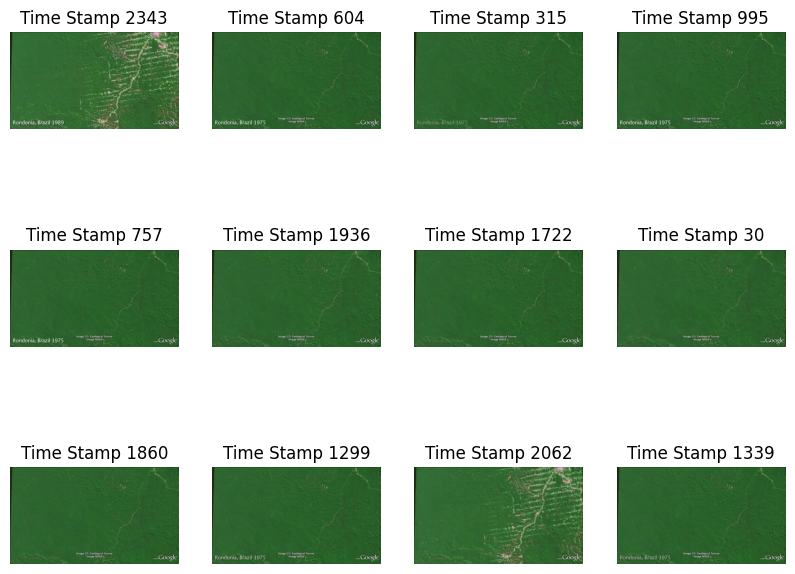

In [12]:
#Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(3, 4, figsize=(10, 8))

data_choice = np.random.choice(range(1, 2500), size=12)
for idx, ax in enumerate(axes.flat):
  ax.imshow(df.iloc[data_choice[idx], 2])
  ax.set_title("Time Stamp " + str(df.iloc[data_choice[idx], 0]))
  ax.axis("off")
plt.show()

In [13]:
#Function to display one image
def displayOne(a, title1 = "Original Image"):
  plt.imshow(a), plt.title(title1)
  plt.show()

#Function to display two images
def displayTwo(a, b, title1 = "Original Image", title2 = "Edited"):
  plt.subplot(121), plt.imshow(a), plt.title(title1)
  plt.subplot(122), plt.imshow(b), plt.title(title2)
  plt.gcf().set_facecolor("#e8eae6")
  plt.show()

#Function to plot the histogram for a given image
def createHistogram(img, bins, range):
  hist = plt.hist(img.ravel(), bins, [range[0], range[1]])
  return hist

## **Data Preprocessing**

In [14]:
#Pick some images for visualization purpose
original_img = img_arr[1900]
original_imgs = [img_arr[50], img_arr[2300]]

### **Resize Images**

In [15]:
def resizeImage(img, height, width):
  #Load the image
  print('Original Image Size: ',
        img.shape)

  #Set dims of the resized image
  height = height
  width = width
  dim = (width, height)
  res_img = cv2.resize(img, dim,
                       interpolation=cv2.INTER_AREA)

  #Check the size of resized image
  print("Resized Image Size: ",
        res_img.shape)
  return res_img

Resized Image
Original Image Size:  (368, 640, 3)
Resized Image Size:  (299, 299, 3)


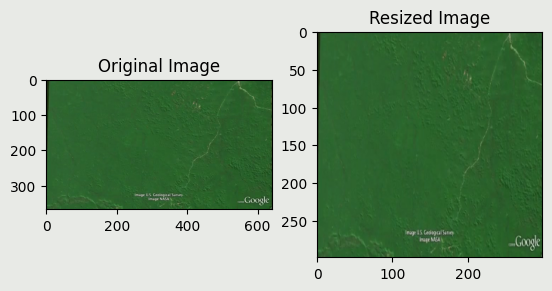

In [16]:
#Resize and visualize an image in the dataset
print("Resized Image")
res_img = resizeImage(original_img, img_height, img_width)
displayTwo(original_img, res_img, "Original Image", "Resized Image")
print(" ")

### **Normalization**
Function written to normalize the pixel value of a given image between 0-255.

In [17]:
def normalizeImage(img):
  normalizedImg = cv2.normalize(img,
                                None,
                                alpha=0,
                                beta=255,
                                norm_type=cv2.NORM_MINMAX)
  return normalizedImg

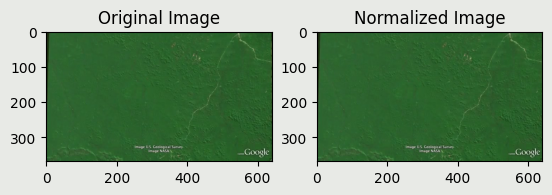

In [18]:
#Apply Normalization to an image in the dataset
res_img = normalizeImage(original_img)
displayTwo(original_img, res_img, "Original Image", "Normalized Image")

#### **Crop Images**
Function written to crop image from the bottom to remove an unnecessary text part.

In [19]:
def cropImage(img):
  x=0
  y=0
  h=640
  w=325
  crop_img = img[x:w, y:h]

  #Check the size of cropped image
  #print("Cropped Image Size: ",crop_img.shape)
  return crop_img

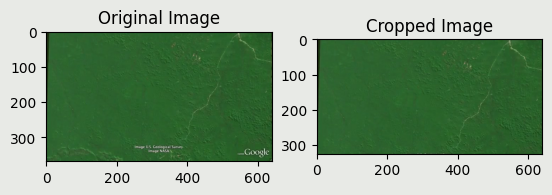

In [20]:
# Resize and visualize an image in the dataset
#print("Cropped Image")
crop_img = cropImage(original_img)
displayTwo(original_img, crop_img, "Original Image", "Cropped Image")
#print(" ")

## **Apply Pre-Processing**

In [21]:
processed_imgs = []

def preprocessImg():
  for img in img_arr:
    normalized_img = normalizeImage(img)
    cropped_img = cropImage(normalized_img)
    resized_img = resizeImage(cropped_img, img_height, img_width)
    processed_imgs.append(resized_img)

  return processed_imgs

In [22]:
# !pip install Keras-Preprocessing
# !pip install tensorflow

## **Prepare Images for the Model**
Function to prepare images to match the requirements of a given model.
1. Convert the image instance into a numpy array.
2. Use `model_name.preprocess_input` to preprocess the image. \This will converts the images from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
3. Reshape the images from (img_width,img_height,3) shape into (1,img_width,img_height,3)

In [23]:
def prepareImageForModel(img):
  #Converts the image instance into a numpy array
  img = img_to_array(img)
  #Prepare the image for the CNN model
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  #Reshape data for the model
  img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
  return img

In [24]:
cnn_imgs = preprocessImg()
print('done')

Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Original Image Size:  (325, 640, 3)
Resized Image Size:  (299, 299, 3)
Origin

In [25]:
dataset = []

for img in tqdm(cnn_imgs):
  img = prepareImageForModel(img)
  img = img.reshape((img.shape[1], img.shape[1], 3))
  dataset.append(img)

100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 3970.46it/s]


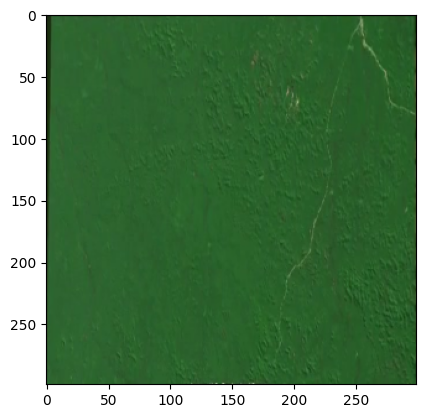

In [26]:
plt.imshow(cnn_imgs[1400])

## **downloading the labels**

### creating the dataset into correct format

In [27]:
cnn_imgs[1]

array([[[ 22,  38,  12],
        [ 24,  39,  16],
        [ 24,  39,  16],
        ...,
        [ 36,  73,  33],
        [ 41,  68,  31],
        [ 36,  59,  23]],

       [[ 23,  39,  13],
        [ 25,  40,  17],
        [ 26,  41,  18],
        ...,
        [ 40,  77,  36],
        [ 43,  69,  32],
        [ 37,  59,  23]],

       [[ 24,  40,  14],
        [ 26,  41,  18],
        [ 28,  43,  20],
        ...,
        [ 44,  81,  40],
        [ 43,  69,  32],
        [ 37,  59,  23]],

       ...,

       [[ 26,  59,  22],
        [ 54,  91,  52],
        [ 56, 100,  57],
        ...,
        [ 46,  88,  42],
        [ 44,  79,  37],
        [ 38,  68,  28]],

       [[ 26,  59,  22],
        [ 54,  91,  52],
        [ 56, 100,  57],
        ...,
        [ 47,  88,  43],
        [ 45,  80,  38],
        [ 40,  70,  29]],

       [[ 26,  59,  22],
        [ 54,  91,  52],
        [ 56, 100,  57],
        ...,
        [ 48,  89,  43],
        [ 45,  80,  38],
        [ 41,  71,  30]]

In [28]:

labels = []
#labels = np.array([])

In [29]:
df=pd.read_csv(DEEP_LEARNING_MODULE_OUTPUTS_FOR_LARGE_DATASET+"/combined_predictions_inceptionv3.csv")
df["Predicted_Class"]


0        Normal
1        Normal
2        Normal
3        Normal
4        Normal
         ...   
2495    Anomaly
2496    Anomaly
2497    Anomaly
2498    Anomaly
2499    Anomaly
Name: Predicted_Class, Length: 2500, dtype: object

In [30]:
print(df.head)

<bound method NDFrame.head of         No Predicted_Class
0        0          Normal
1        1          Normal
2        2          Normal
3        3          Normal
4        4          Normal
...    ...             ...
2495  2495         Anomaly
2496  2496         Anomaly
2497  2497         Anomaly
2498  2498         Anomaly
2499  2499         Anomaly

[2500 rows x 2 columns]>


In [31]:
for prediction in tqdm(df["Predicted_Class"]):
    if(prediction =="Normal"):
        labels.append(0)
    else:
        labels.append(1)


100%|█████████████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 2514570.74it/s]


In [32]:
# labels

In [33]:
len(dataset)
dataset = np.asarray(dataset)
print(dataset.shape)


len(labels)
labels = np.asarray(labels)
print(labels)

(2500, 299, 299, 3)
[0 0 0 ... 1 1 1]


In [34]:
print(dataset.shape)
print(labels[2496])

(2500, 299, 299, 3)
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.49803925].


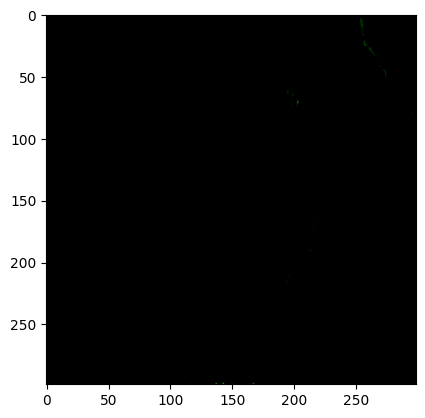

In [35]:
plt.imshow(dataset[1400])


In [36]:
dataset.shape

(2500, 299, 299, 3)

# Feature Extraction

# 1. InceptionV3


In [37]:
# resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, #to remove the classification layers
#                                           weights='imagenet', #trains the model using imagenet weights
#                                           input_shape=SHAPE #define the input shape of the model
#                                           )

# for layer in resnet50.layers:
#     layer.trainable = False
#   #Convert the model into a sequential model
# model = Sequential()(resnet50.layers[-1].output)
# #Add GlobalMaxPooling2D layer for dimension reduction
# model = GlobalMaxPooling2D()(model)
# model = Model(inputs=resnet50.inputs, outputs=model)

In [38]:
inceptionv3 = tf.keras.applications.inception_v3.InceptionV3(include_top=False, #to remove the classification layers
                                          weights='imagenet', #trains the model using imagenet weights
                                          input_shape=SHAPE #define the input shape of the model
                                          )

for layer in inceptionv3.layers:
    layer.trainable = False

# Add GlobalMaxPooling2D layer directly to inceptionv3 output
model = GlobalMaxPooling2D()(inceptionv3.output)

# Create the final Model
model = Model(inputs=inceptionv3.inputs, outputs=model)

In [39]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 149, 149, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 149, 149, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 149, 149, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 147, 147, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 147, 147, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 147, 147, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 147, 147, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 147, 147, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 147, 147, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 73, 73, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 73, 73, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 73, 73, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 73, 73, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 71, 71, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

## Adding a trainable fully connected layer for classification.

In [40]:
inceptionModel = Sequential()
inceptionModel.add(model)
inceptionModel.add(Dense(512, activation='relu', input_dim=(None,512)))
inceptionModel.add(Dense(1, activation='sigmoid'))

C:\Users\Nethmee Sellahewa\.conda\envs\my_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
inceptionModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,852,385 (87.17 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

************************************

In [42]:
utils.plot_model(inceptionModel, show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## adding weights

* weights are added in order to avoid class imbalance


* weights = compute_class_weight(class_weight ='balanced',
                               classes= np.unique(trainY),
                               y= trainY


In [43]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight ='balanced',
                               classes= np.unique(labels),
                               y= labels)




cw = dict(zip( np.unique(labels), weights))
print(cw)

{np.int64(0): np.float64(0.6265664160401002), np.int64(1): np.float64(2.4752475247524752)}


In [44]:
from keras import optimizers
inceptionModel.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [45]:
print(f"Dataset shape: {dataset.shape}, Labels shape: {labels.shape}")
print(f"Number of unique labels: {len(np.unique(labels))}")

Dataset shape: (2500, 299, 299, 3), Labels shape: (2500,)
Number of unique labels: 2


In [46]:
history = inceptionModel.fit(dataset, labels,class_weight=cw, epochs=30)

Epoch 1/30


C:\Users\Nethmee Sellahewa\.conda\envs\my_env\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 299, 299, 3))
  warnings.warn(msg)


79/79 ━━━━━━━━━━━━━━━━━━━━ 48s 555ms/step - accuracy: 0.9302 - loss: 0.1668
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 562ms/step - accuracy: 0.9989 - loss: 0.0232
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 45s 566ms/step - accuracy: 0.9977 - loss: 0.0278
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 45s 567ms/step - accuracy: 0.9974 - loss: 0.0273
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 575ms/step - accuracy: 0.9988 - loss: 0.0263
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 589ms/step - accuracy: 0.9990 - loss: 0.0156
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 561ms/step - accuracy: 0.9960 - loss: 0.0342
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 559ms/step - accuracy: 0.9992 - loss: 0.0166
Epoch 9/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 48s 604ms/step - accuracy: 0.9961 - loss: 0.0272
Epoch 10/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 49s 615ms/step - accuracy: 0.9990 - loss: 0.0078
Epoch 11/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 49s 621ms/step - accuracy: 0.9935 - loss: 0.0361
Epoch 12/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 49s 621ms/ste

### Plot the Training and Vaidation accuracy

In [47]:
history.history['accuracy']

[0.9800000190734863,
 0.9983999729156494,
 0.9983999729156494,
 0.9980000257492065,
 0.9983999729156494,
 0.9983999729156494,
 0.9976000189781189,
 0.9983999729156494,
 0.9980000257492065,
 0.9983999729156494,
 0.9968000054359436,
 0.9983999729156494,
 0.9980000257492065,
 0.996399998664856,
 0.9983999729156494,
 0.9983999729156494,
 0.9983999729156494,
 0.9968000054359436,
 0.9983999729156494,
 0.9987999796867371,
 0.9955999851226807,
 0.9959999918937683,
 0.9980000257492065,
 0.9968000054359436,
 0.9983999729156494,
 0.9980000257492065,
 0.9968000054359436,
 0.9947999715805054,
 0.9972000122070312,
 0.9976000189781189]

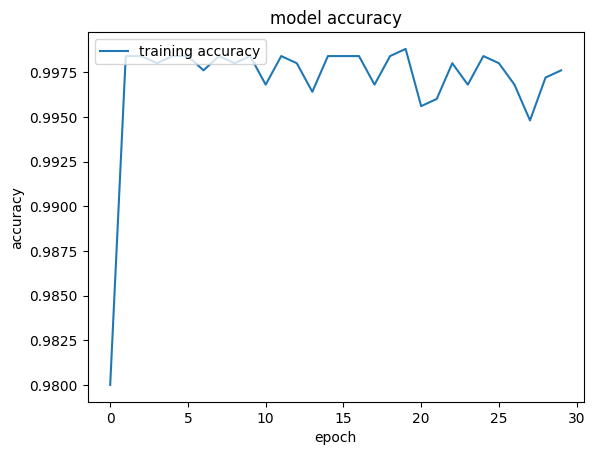

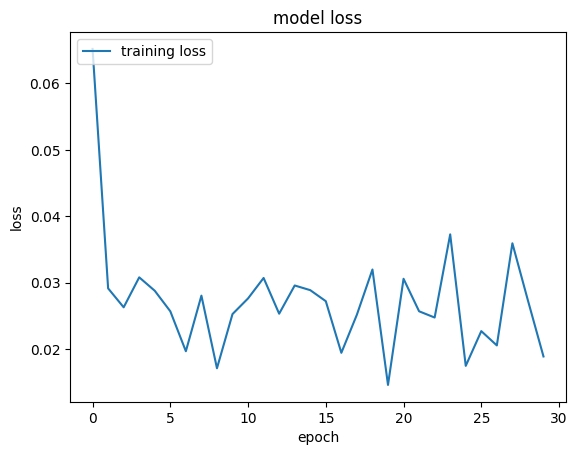

In [48]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss'], loc='upper left')

### Adding confusion matrix for the dataset


#### Get Model predictions

In [49]:
x= dataset



In [50]:


# predictions for the data (2500 images)
trure_targets =  labels

#confusion_matrix(trure_targets, predX)

In [51]:
predictions =[]
predX=inceptionModel.predict(x)

for pred in predX:
    #print(pred.shape)

    if(pred>0 and pred<=0.5):
        predictions.append(0)
    else:
        predictions.append(1)


C:\Users\Nethmee Sellahewa\.conda\envs\my_env\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 299, 299, 3))
  warnings.warn(msg)


79/79 ━━━━━━━━━━━━━━━━━━━━ 51s 622ms/step


In [52]:
predictions =  np.asarray(predictions)
print(predictions.shape)
print(predictions[2000])
print(labels[2000])

print(predictions[2012])
print(labels[2012])

(2500,)
1
1
1
1


model.predict(
    trainX
)

<Axes: >

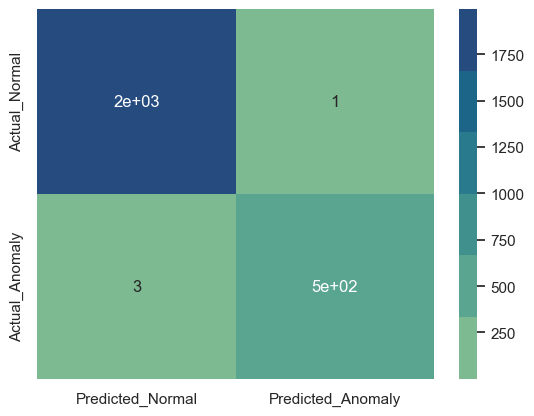

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()
colorMap = sns.color_palette("crest")



data = confusion_matrix(labels, predictions,labels=[0,1])
df = pd.DataFrame(data,index = ["Actual_Normal","Actual_Anomaly"],columns=['Predicted_Normal','Predicted_Anomaly'],dtype=int)
sns.heatmap(df, annot=True, cmap=colorMap)

In [54]:
#df = pd.DataFrame(data,index = ["Actual_Normal","Actual_Anomaly"],columns=['Predicted_Normal','Predicted_Anomaly'],dtype=int)
df

Predicted_Normal  Predicted_Anomaly
Actual_Normal               1994                  1
Actual_Anomaly                 3                502

### Save the model

In [55]:

 model.save('inceptionModel.h5')

#### Saving the model in Google Drive


In [56]:


# Save the model to your Google Drive
model_save_path = os.path.join(BASE_PATH, 'inceptionModel.h5')
inceptionModel.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: C:/nethmee/Inception/content/drive/MyDrive/Colab Notebooks/FYP - Anomaly Detection in Image Streams\inceptionModel.h5


#### Load the model


In [57]:
from keras.models import load_model
model = load_model(BASE_PATH+'/inceptionModel.h5')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 2048)                │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,852,387 (87.17 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 2 (12.00 B)

# **Explainability of the feature extractors**

Images selected are as follows

* An image from the normal behaviour :- dataset[100]
* An image from the normal behavour but close to the anomalous behaviour : dataset[1900]
* An image from the anomalous behavour but close to the normal behaviour : dataset[2259]
* An image from the anomalous behaviour: dataset[2450]

Text(0.5, 1.0, '2450th')

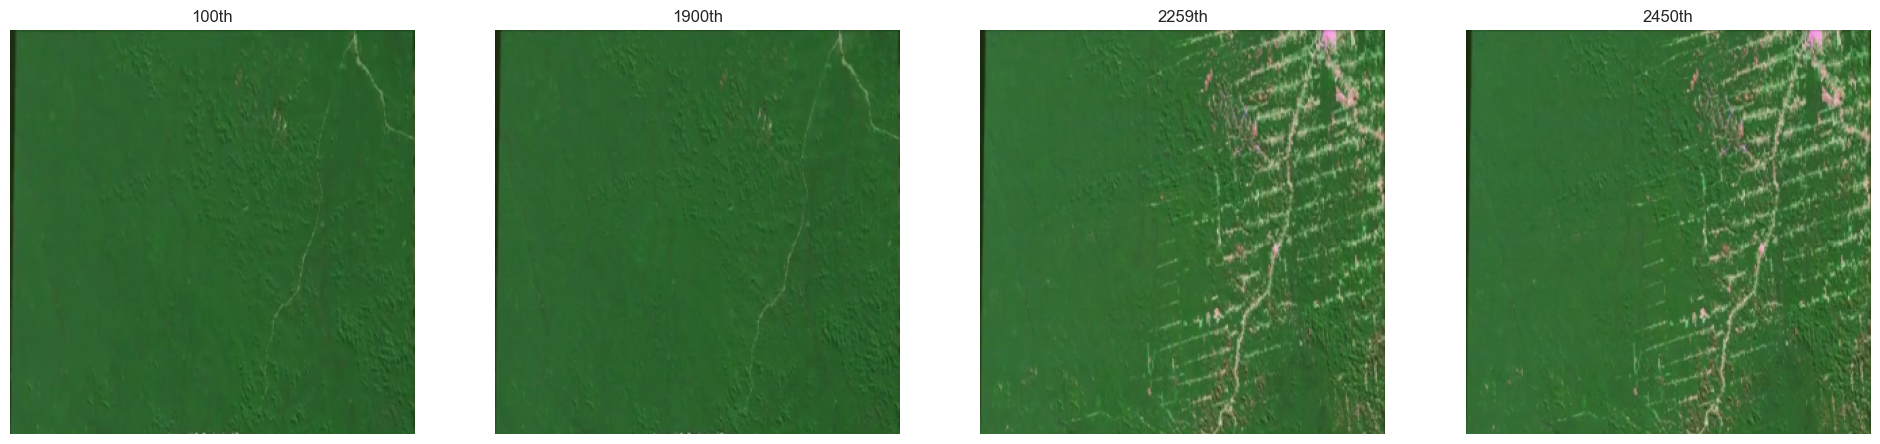

In [58]:
imgFig = plt.figure(figsize=(24, 10))
# setting values to rows and column variables
rows = 1
columns = 4

imgFig.add_subplot(rows, columns, 1)
plt.imshow(cnn_imgs[99])
plt.axis('off')
plt.title("100th")

imgFig.add_subplot(rows, columns, 2)
plt.imshow(cnn_imgs[1899])
plt.axis('off')
plt.title("1900th")

imgFig.add_subplot(rows, columns, 3)
plt.imshow(cnn_imgs[2259])
plt.axis('off')
plt.title("2259th")

imgFig.add_subplot(rows, columns, 4)
plt.imshow(cnn_imgs[2449])
plt.axis('off')
plt.title("2450th")


### SHAP exlpainers


In [59]:
# !pip install shap

In [60]:
import shap

class_names = ["Anomaly"]

class_names= np.asarray(class_names)
masker_blur = shap.maskers.Image("blur(128,128)", cnn_imgs[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(model, masker_blur, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(dataset[0:1], max_evals=5000, batch_size=50,outputs=shap.Explanation.argsort.flip)

C:\Users\Nethmee Sellahewa\.conda\envs\my_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PartitionExplainer explainer: 2it [02:37, 157.51s/it]                                                                  


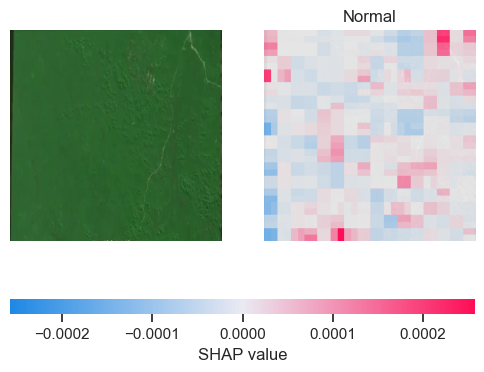

In [61]:
shap.image_plot(shap_values_fine,np.array(cnn_imgs[0:1]),[["Normal"]])

In [62]:
# print(shap_values_fine)

### 100th Image

PartitionExplainer explainer: 2it [02:40, 160.70s/it]                                                                  


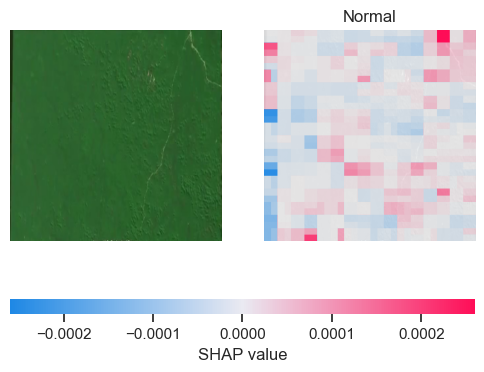

In [63]:

class_names = ["Anomaly"]

class_names= np.asarray(class_names)
masker_blur = shap.maskers.Image("blur(128,128)", dataset[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(model, masker_blur, output_names=class_names)


# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(dataset[99:100], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values_fine,np.array(cnn_imgs[99:100]),[["Normal"]])

### 1900th image

In [64]:
class_names= np.asarray(class_names)
masker_blur = shap.maskers.Image("blur(128,128)", dataset[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(model, masker_blur, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(dataset[1899:1900], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])

PartitionExplainer explainer: 2it [02:39, 159.15s/it]                                                                  


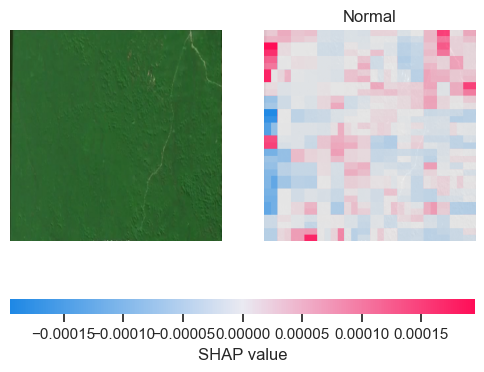

In [65]:
shap.image_plot(shap_values_fine,np.array(cnn_imgs[1899:1900]),[["Normal"]])

### 2259th image

In [66]:
class_names= np.asarray(class_names)
masker_blur = shap.maskers.Image("blur(128,128)", dataset[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(model, masker_blur, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(dataset[2258:2259], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])

PartitionExplainer explainer: 2it [02:36, 156.79s/it]                                                                  


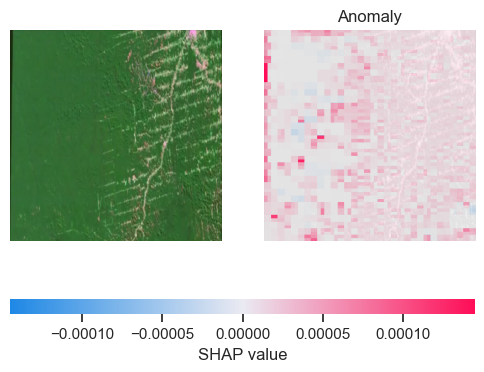

In [67]:
shap.image_plot(shap_values_fine,np.array(cnn_imgs[2258:2259]),[["Anomaly"]])

### 2450th image

In [68]:


class_names= np.asarray(class_names)
masker_blur = shap.maskers.Image("blur(128,128)", dataset[0].shape)



# create an explainer with model and iresNetModelmage masker
explainer_blur = shap.Explainer(model, masker_blur, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(dataset[2449:2450], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])

PartitionExplainer explainer: 2it [02:41, 161.20s/it]                                                                  


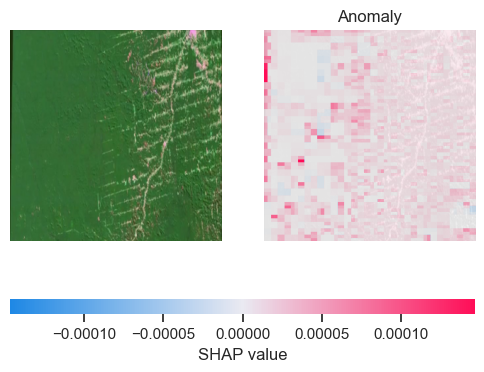

In [69]:
shap.image_plot(shap_values_fine,np.array(cnn_imgs[2449:2450]),[["Anomaly"]],show=False)

In [70]:
# !pip install lime

In [71]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

from lime import lime_image
from skimage.segmentation import mark_boundaries

lime_explainer = lime_image.LimeImageExplainer(feature_selection ='auto' )


#explanation = lime_explainer.explain_instance(trainX[1400].astype('double'), model.predict,  
                                         #top_labels=2, hide_color=0, num_samples=1000)
    
explanation = lime_explainer.explain_instance(dataset[1400].astype('double'), resNetModel.predict)



In [72]:
explainer = lime_image.LimeImageExplainer(random_state=42)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  1%|▊                                                                               | 10/1000 [00:01<02:36,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


  2%|█▌                                                                              | 20/1000 [00:01<01:20, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  3%|██▍                                                                             | 30/1000 [00:02<00:55, 17.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


  4%|███▏                                                                            | 40/1000 [00:02<00:44, 21.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  5%|████                                                                            | 50/1000 [00:02<00:37, 25.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


  6%|████▊                                                                           | 60/1000 [00:02<00:33, 28.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


  7%|█████▌                                                                          | 70/1000 [00:03<00:30, 30.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


  8%|██████▍                                                                         | 80/1000 [00:03<00:28, 31.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


  9%|███████▏                                                                        | 90/1000 [00:03<00:27, 33.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 10%|███████▉                                                                       | 100/1000 [00:04<00:26, 34.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 11%|████████▋                                                                      | 110/1000 [00:04<00:25, 35.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 12%|█████████▍                                                                     | 120/1000 [00:04<00:24, 36.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 13%|██████████▎                                                                    | 130/1000 [00:04<00:23, 36.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 14%|███████████                                                                    | 140/1000 [00:05<00:23, 36.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 15%|███████████▊                                                                   | 150/1000 [00:05<00:23, 36.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 16%|████████████▋                                                                  | 160/1000 [00:05<00:23, 36.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:05<00:23, 35.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 18%|██████████████▏                                                                | 180/1000 [00:06<00:22, 36.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 19%|███████████████                                                                | 190/1000 [00:06<00:22, 36.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 20%|███████████████▊                                                               | 200/1000 [00:06<00:21, 37.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 21%|████████████████▌                                                              | 210/1000 [00:07<00:20, 38.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 22%|█████████████████▍                                                             | 220/1000 [00:07<00:20, 38.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 23%|██████████████████▏                                                            | 230/1000 [00:07<00:20, 37.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 24%|██████████████████▉                                                            | 240/1000 [00:07<00:20, 36.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 25%|███████████████████▊                                                           | 250/1000 [00:08<00:20, 36.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 26%|████████████████████▌                                                          | 260/1000 [00:08<00:20, 35.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 27%|█████████████████████▎                                                         | 270/1000 [00:08<00:19, 36.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 28%|██████████████████████                                                         | 280/1000 [00:08<00:19, 36.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 29%|██████████████████████▉                                                        | 290/1000 [00:09<00:19, 37.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 30%|███████████████████████▋                                                       | 300/1000 [00:09<00:18, 37.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 31%|████████████████████████▍                                                      | 310/1000 [00:09<00:18, 37.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [00:10<00:18, 37.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 33%|██████████████████████████                                                     | 330/1000 [00:10<00:17, 37.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [00:10<00:17, 38.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [00:10<00:16, 38.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [00:11<00:16, 38.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [00:11<00:16, 39.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 38%|██████████████████████████████                                                 | 380/1000 [00:11<00:16, 37.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [00:11<00:16, 37.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [00:12<00:15, 37.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [00:12<00:15, 37.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [00:12<00:15, 38.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [00:12<00:14, 38.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [00:13<00:14, 38.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [00:13<00:14, 38.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [00:13<00:14, 38.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [00:13<00:13, 37.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [00:14<00:13, 37.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [00:14<00:13, 37.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [00:14<00:13, 37.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [00:15<00:13, 37.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [00:15<00:12, 37.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [00:15<00:12, 37.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [00:15<00:12, 37.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [00:16<00:11, 37.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [00:16<00:11, 37.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [00:16<00:11, 38.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [00:16<00:10, 38.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [00:17<00:10, 39.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [00:17<00:10, 39.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [00:17<00:10, 38.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [00:17<00:10, 37.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [00:18<00:09, 37.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [00:18<00:09, 37.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [00:18<00:09, 38.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [00:18<00:08, 38.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [00:19<00:08, 38.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [00:19<00:08, 38.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [00:19<00:07, 38.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [00:19<00:07, 38.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [00:20<00:07, 38.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [00:20<00:07, 38.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [00:20<00:06, 38.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [00:20<00:06, 38.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [00:21<00:06, 38.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [00:21<00:06, 38.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [00:21<00:05, 38.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [00:22<00:05, 38.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [00:22<00:05, 38.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [00:22<00:05, 38.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [00:22<00:04, 38.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [00:23<00:04, 37.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [00:23<00:04, 37.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [00:23<00:04, 36.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [00:23<00:04, 36.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [00:24<00:03, 36.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [00:24<00:03, 36.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [00:24<00:03, 36.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [00:25<00:03, 36.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [00:25<00:02, 36.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [00:25<00:02, 36.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [00:25<00:02, 36.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [00:26<00:01, 37.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [00:26<00:01, 37.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [00:26<00:01, 37.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [00:26<00:01, 36.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [00:27<00:00, 36.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [00:27<00:00, 36.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [00:27<00:00, 36.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.69it/s]


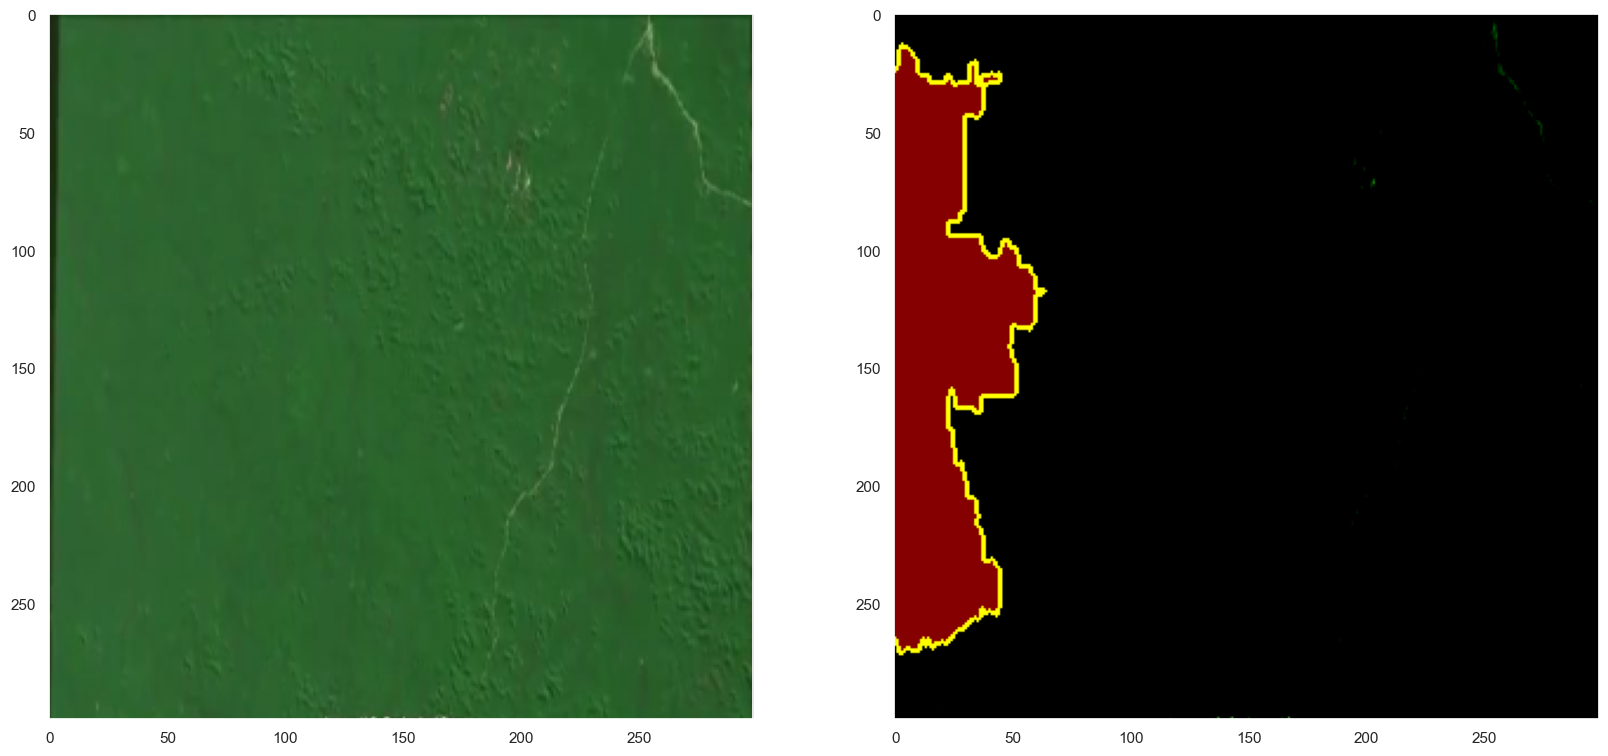

In [73]:
#100th
explanation100 = explainer.explain_instance(
         dataset[99],
         model.predict
)

image, mask = explanation100.get_image_and_mask(
         explanation100.top_labels[0],
         positive_only=False,
         hide_rest=False)
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.grid(False)
plt.imshow(cnn_imgs[99])
plt.subplot(1, 2, 2)
plt.grid(False)
plt.imshow(mark_boundaries(image, mask))

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


  1%|▊                                                                               | 10/1000 [00:00<00:25, 39.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  2%|█▌                                                                              | 20/1000 [00:00<00:25, 38.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  3%|██▍                                                                             | 30/1000 [00:00<00:25, 38.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


  4%|███▏                                                                            | 40/1000 [00:01<00:24, 38.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  5%|████                                                                            | 50/1000 [00:01<00:24, 38.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


  6%|████▊                                                                           | 60/1000 [00:01<00:24, 38.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


  7%|█████▌                                                                          | 70/1000 [00:01<00:23, 38.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


  8%|██████▍                                                                         | 80/1000 [00:02<00:23, 38.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


  9%|███████▏                                                                        | 90/1000 [00:02<00:23, 39.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 10%|███████▉                                                                       | 100/1000 [00:02<00:22, 39.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


 11%|████████▋                                                                      | 110/1000 [00:02<00:22, 39.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 12%|█████████▍                                                                     | 120/1000 [00:03<00:22, 38.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 13%|██████████▎                                                                    | 130/1000 [00:03<00:22, 38.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 14%|███████████                                                                    | 140/1000 [00:03<00:22, 38.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 15%|███████████▊                                                                   | 150/1000 [00:03<00:22, 38.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 16%|████████████▋                                                                  | 160/1000 [00:04<00:22, 37.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:04<00:21, 38.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 18%|██████████████▏                                                                | 180/1000 [00:04<00:21, 38.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


 19%|███████████████                                                                | 190/1000 [00:04<00:20, 38.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 20%|███████████████▊                                                               | 200/1000 [00:05<00:20, 38.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 21%|████████████████▌                                                              | 210/1000 [00:05<00:20, 39.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 22%|█████████████████▍                                                             | 220/1000 [00:05<00:20, 38.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 23%|██████████████████▏                                                            | 230/1000 [00:05<00:20, 38.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 24%|██████████████████▉                                                            | 240/1000 [00:06<00:19, 38.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 25%|███████████████████▊                                                           | 250/1000 [00:06<00:19, 38.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 26%|████████████████████▌                                                          | 260/1000 [00:06<00:19, 38.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 27%|█████████████████████▎                                                         | 270/1000 [00:07<00:19, 38.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 28%|██████████████████████                                                         | 280/1000 [00:07<00:18, 38.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 29%|██████████████████████▉                                                        | 290/1000 [00:07<00:18, 37.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 30%|███████████████████████▋                                                       | 300/1000 [00:07<00:18, 37.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 31%|████████████████████████▍                                                      | 310/1000 [00:08<00:18, 37.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [00:08<00:18, 37.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 33%|██████████████████████████                                                     | 330/1000 [00:08<00:17, 37.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [00:08<00:17, 37.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [00:09<00:16, 38.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [00:09<00:16, 38.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [00:09<00:16, 38.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 38%|██████████████████████████████                                                 | 380/1000 [00:09<00:16, 37.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [00:10<00:16, 35.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [00:10<00:17, 34.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [00:10<00:16, 34.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [00:11<00:16, 35.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [00:11<00:15, 36.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [00:11<00:15, 35.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [00:11<00:14, 37.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [00:12<00:14, 36.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [00:12<00:14, 36.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [00:12<00:14, 35.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [00:13<00:14, 36.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [00:13<00:13, 36.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [00:13<00:13, 36.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [00:13<00:13, 36.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [00:14<00:13, 35.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [00:14<00:12, 36.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [00:14<00:12, 36.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [00:14<00:12, 36.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [00:15<00:11, 36.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [00:15<00:11, 37.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [00:15<00:11, 37.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [00:15<00:10, 37.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [00:16<00:10, 37.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [00:16<00:10, 37.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [00:16<00:09, 37.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [00:17<00:09, 37.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [00:17<00:09, 38.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [00:17<00:08, 37.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [00:17<00:08, 38.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [00:18<00:08, 38.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [00:18<00:08, 38.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [00:18<00:07, 38.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [00:18<00:07, 38.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [00:19<00:07, 38.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [00:19<00:07, 38.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [00:19<00:06, 38.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [00:19<00:06, 38.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [00:20<00:06, 38.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [00:20<00:05, 38.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [00:20<00:05, 38.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [00:20<00:05, 38.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [00:21<00:05, 38.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [00:21<00:04, 38.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [00:21<00:04, 38.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [00:21<00:04, 38.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [00:22<00:04, 38.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [00:22<00:03, 38.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [00:22<00:03, 38.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [00:23<00:03, 39.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [00:23<00:03, 39.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [00:23<00:02, 38.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [00:23<00:02, 36.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [00:24<00:02, 36.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [00:24<00:02, 35.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [00:24<00:01, 35.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [00:24<00:01, 36.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [00:25<00:01, 36.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [00:25<00:01, 37.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [00:26<00:01, 21.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [00:26<00:00, 24.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [00:26<00:00, 26.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.69it/s]


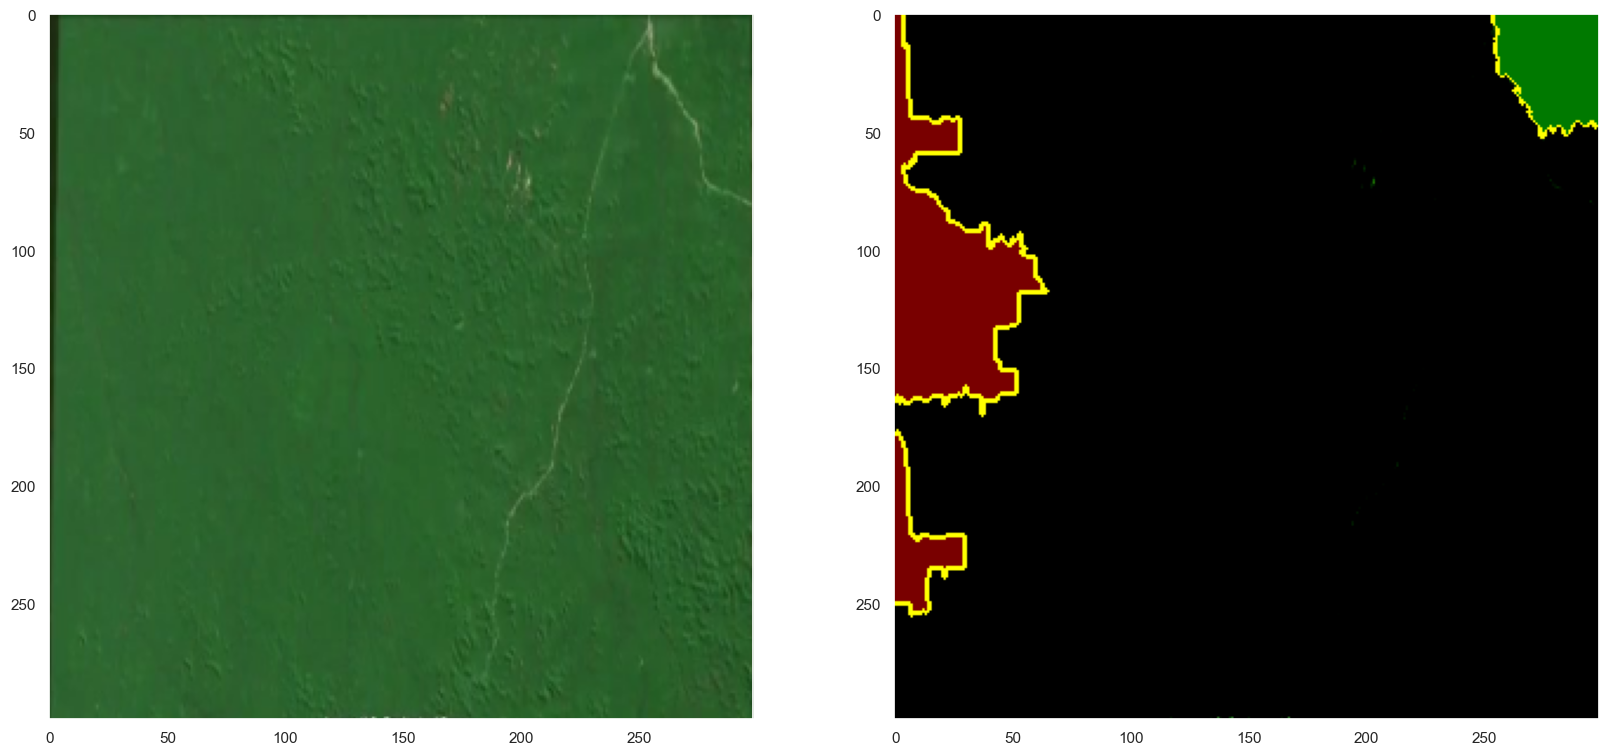

In [74]:
#1900th
explanation1900 = explainer.explain_instance(
         dataset[1899],
         model.predict
)

image, mask = explanation1900.get_image_and_mask(
         explanation1900.top_labels[0],
         positive_only=False,
         hide_rest=False)
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.grid(False)
plt.imshow(cnn_imgs[1899])
plt.subplot(1, 2, 2)
plt.grid(False)
plt.imshow(mark_boundaries(image, mask))

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


  1%|▊                                                                               | 10/1000 [00:00<00:26, 37.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


  2%|█▌                                                                              | 20/1000 [00:00<00:27, 35.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


  3%|██▍                                                                             | 30/1000 [00:00<00:28, 34.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


  4%|███▏                                                                            | 40/1000 [00:01<00:28, 33.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


  5%|████                                                                            | 50/1000 [00:01<00:28, 33.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


  6%|████▊                                                                           | 60/1000 [00:01<00:27, 34.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


  7%|█████▌                                                                          | 70/1000 [00:02<00:26, 34.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


  8%|██████▍                                                                         | 80/1000 [00:02<00:25, 36.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


  9%|███████▏                                                                        | 90/1000 [00:02<00:24, 36.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 10%|███████▉                                                                       | 100/1000 [00:02<00:24, 36.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 11%|████████▋                                                                      | 110/1000 [00:03<00:23, 37.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 12%|█████████▍                                                                     | 120/1000 [00:03<00:23, 36.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 13%|██████████▎                                                                    | 130/1000 [00:03<00:23, 36.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 14%|███████████                                                                    | 140/1000 [00:03<00:23, 36.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 15%|███████████▊                                                                   | 150/1000 [00:04<00:23, 35.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 16%|████████████▋                                                                  | 160/1000 [00:04<00:23, 36.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:04<00:22, 36.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 18%|██████████████▏                                                                | 180/1000 [00:04<00:22, 36.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 19%|███████████████                                                                | 190/1000 [00:05<00:21, 37.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 20%|███████████████▊                                                               | 200/1000 [00:05<00:21, 36.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 21%|████████████████▌                                                              | 210/1000 [00:05<00:21, 37.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 22%|█████████████████▍                                                             | 220/1000 [00:06<00:21, 37.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 23%|██████████████████▏                                                            | 230/1000 [00:06<00:20, 37.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 24%|██████████████████▉                                                            | 240/1000 [00:06<00:20, 37.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 25%|███████████████████▊                                                           | 250/1000 [00:06<00:19, 37.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 26%|████████████████████▌                                                          | 260/1000 [00:07<00:19, 37.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 27%|█████████████████████▎                                                         | 270/1000 [00:07<00:19, 37.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 28%|██████████████████████                                                         | 280/1000 [00:07<00:19, 37.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 29%|██████████████████████▉                                                        | 290/1000 [00:07<00:18, 37.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 30%|███████████████████████▋                                                       | 300/1000 [00:08<00:18, 37.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 31%|████████████████████████▍                                                      | 310/1000 [00:08<00:18, 37.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [00:08<00:18, 37.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


 33%|██████████████████████████                                                     | 330/1000 [00:08<00:17, 37.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [00:09<00:17, 38.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [00:09<00:17, 36.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [00:09<00:17, 36.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [00:10<00:17, 36.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 38%|██████████████████████████████                                                 | 380/1000 [00:10<00:17, 36.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [00:10<00:16, 36.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [00:10<00:16, 36.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [00:11<00:16, 36.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [00:11<00:15, 36.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [00:11<00:15, 36.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [00:12<00:15, 36.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [00:12<00:15, 36.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [00:12<00:14, 36.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [00:12<00:14, 36.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [00:13<00:14, 36.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [00:13<00:13, 36.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [00:13<00:13, 36.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [00:13<00:13, 36.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [00:14<00:13, 36.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [00:14<00:13, 35.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [00:14<00:13, 35.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [00:15<00:13, 34.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [00:15<00:12, 34.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [00:15<00:12, 34.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [00:15<00:12, 34.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [00:16<00:11, 34.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [00:16<00:11, 34.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [00:16<00:11, 35.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [00:17<00:10, 34.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [00:17<00:10, 35.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [00:17<00:10, 35.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [00:17<00:09, 35.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [00:18<00:09, 35.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [00:18<00:09, 35.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [00:18<00:09, 35.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [00:19<00:08, 34.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [00:19<00:08, 34.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [00:19<00:08, 34.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [00:19<00:07, 35.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [00:20<00:07, 36.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [00:20<00:07, 36.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [00:20<00:06, 36.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [00:21<00:06, 36.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [00:21<00:06, 37.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [00:21<00:05, 37.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [00:21<00:05, 37.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [00:22<00:05, 37.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [00:22<00:05, 37.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [00:22<00:04, 37.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [00:22<00:04, 37.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [00:23<00:04, 37.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [00:23<00:04, 37.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [00:23<00:03, 37.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [00:23<00:03, 37.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [00:24<00:03, 37.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [00:24<00:02, 37.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [00:24<00:02, 37.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [00:25<00:02, 37.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [00:25<00:02, 36.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [00:25<00:02, 31.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [00:26<00:01, 31.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [00:26<00:01, 31.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [00:26<00:01, 32.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [00:26<00:00, 33.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [00:27<00:00, 32.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 429s 429s/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [07:36<02:08, 12.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:37<00:00,  2.19it/s]


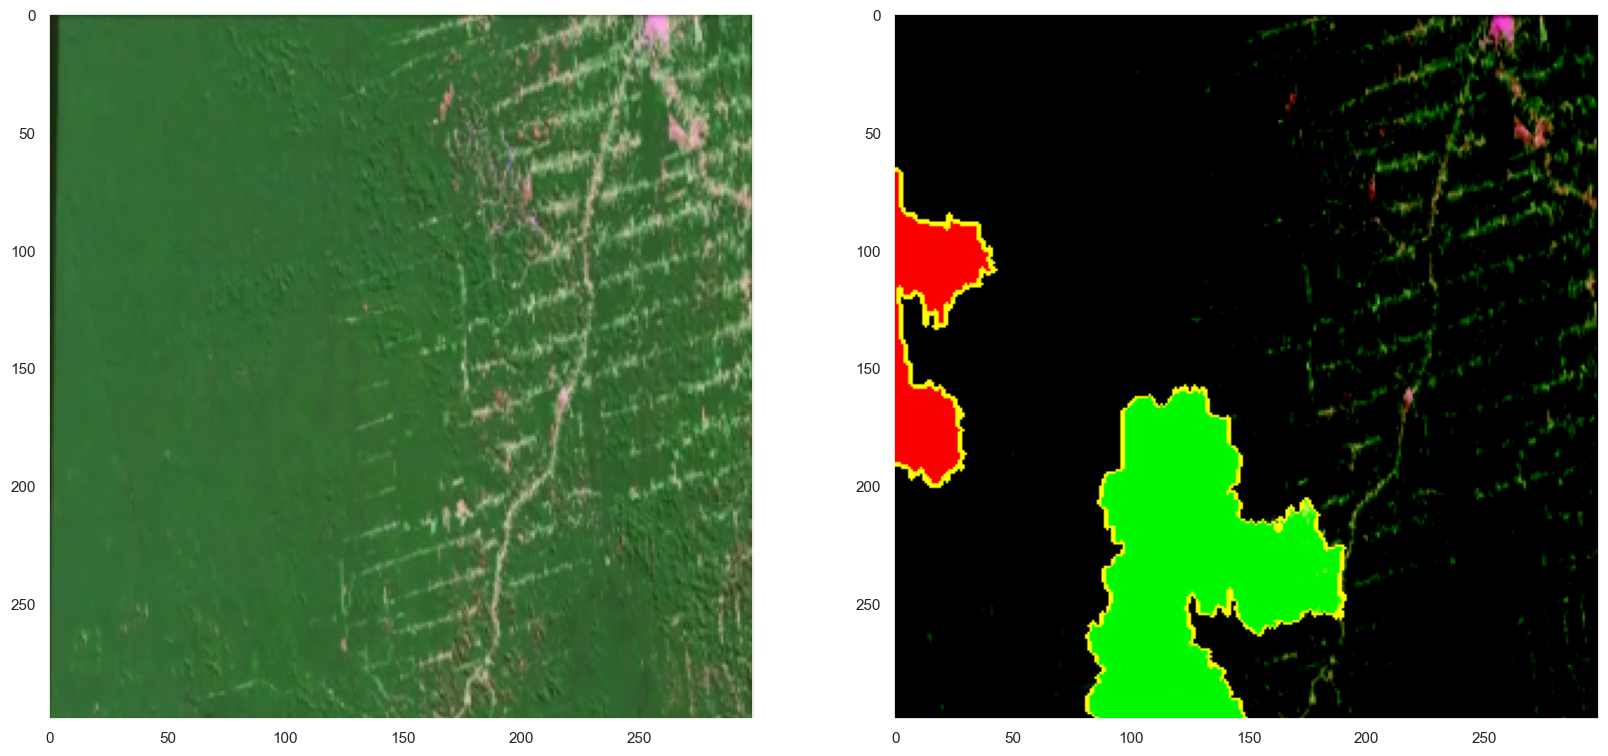

In [75]:
#2259th
explanation2259 = explainer.explain_instance(
         dataset[2258],
         model.predict
)

image, mask = explanation2259.get_image_and_mask(
         explanation2259.top_labels[0],
         positive_only=False,
         hide_rest=False)
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.grid(False)
plt.imshow(cnn_imgs[2258])
plt.subplot(1, 2, 2)
plt.grid(False)
plt.imshow(mark_boundaries(image, mask))

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


  1%|▊                                                                               | 10/1000 [00:00<00:33, 29.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


  2%|█▌                                                                              | 20/1000 [00:00<00:35, 27.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


  3%|██▍                                                                             | 30/1000 [00:01<00:32, 29.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


  4%|███▏                                                                            | 40/1000 [00:01<00:31, 30.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


  5%|████                                                                            | 50/1000 [00:01<00:30, 30.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


  6%|████▊                                                                           | 60/1000 [00:01<00:29, 31.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


  7%|█████▌                                                                          | 70/1000 [00:02<00:29, 31.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


  8%|██████▍                                                                         | 80/1000 [00:02<00:28, 32.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


  9%|███████▏                                                                        | 90/1000 [00:02<00:29, 30.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 10%|███████▉                                                                       | 100/1000 [00:03<00:28, 31.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 11%|████████▋                                                                      | 110/1000 [00:03<00:28, 31.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 12%|█████████▍                                                                     | 120/1000 [00:03<00:27, 32.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


 13%|██████████▎                                                                    | 130/1000 [00:04<00:27, 31.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 14%|███████████                                                                    | 140/1000 [00:04<00:26, 32.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


 15%|███████████▊                                                                   | 150/1000 [00:04<00:27, 31.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 16%|████████████▋                                                                  | 160/1000 [00:05<00:27, 30.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 17%|█████████████▍                                                                 | 170/1000 [00:05<00:26, 31.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 18%|██████████████▏                                                                | 180/1000 [00:05<00:26, 31.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 19%|███████████████                                                                | 190/1000 [00:06<00:25, 32.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 20%|███████████████▊                                                               | 200/1000 [00:06<00:24, 32.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 21%|████████████████▌                                                              | 210/1000 [00:06<00:23, 33.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 22%|█████████████████▍                                                             | 220/1000 [00:06<00:23, 33.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 23%|██████████████████▏                                                            | 230/1000 [00:07<00:22, 33.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 24%|██████████████████▉                                                            | 240/1000 [00:07<00:22, 34.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 25%|███████████████████▊                                                           | 250/1000 [00:07<00:21, 34.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 26%|████████████████████▌                                                          | 260/1000 [00:08<00:21, 34.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 27%|█████████████████████▎                                                         | 270/1000 [00:08<00:20, 35.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 28%|██████████████████████                                                         | 280/1000 [00:08<00:20, 35.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 29%|██████████████████████▉                                                        | 290/1000 [00:08<00:19, 35.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 30%|███████████████████████▋                                                       | 300/1000 [00:09<00:19, 35.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


 31%|████████████████████████▍                                                      | 310/1000 [00:09<00:19, 35.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


 32%|█████████████████████████▎                                                     | 320/1000 [00:09<00:19, 35.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 33%|██████████████████████████                                                     | 330/1000 [00:10<00:18, 35.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


 34%|██████████████████████████▊                                                    | 340/1000 [00:10<00:18, 36.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


 35%|███████████████████████████▋                                                   | 350/1000 [00:10<00:18, 35.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 36%|████████████████████████████▍                                                  | 360/1000 [00:10<00:18, 35.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 37%|█████████████████████████████▏                                                 | 370/1000 [00:11<00:17, 35.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 38%|██████████████████████████████                                                 | 380/1000 [00:11<00:17, 35.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


 39%|██████████████████████████████▊                                                | 390/1000 [00:11<00:17, 35.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 40%|███████████████████████████████▌                                               | 400/1000 [00:11<00:16, 35.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 41%|████████████████████████████████▍                                              | 410/1000 [00:12<00:16, 35.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 42%|█████████████████████████████████▏                                             | 420/1000 [00:12<00:16, 35.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


 43%|█████████████████████████████████▉                                             | 430/1000 [00:12<00:15, 35.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 44%|██████████████████████████████████▊                                            | 440/1000 [00:13<00:15, 35.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 45%|███████████████████████████████████▌                                           | 450/1000 [00:13<00:15, 35.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


 46%|████████████████████████████████████▎                                          | 460/1000 [00:13<00:15, 35.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [00:13<00:14, 36.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [00:14<00:14, 35.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [00:14<00:14, 34.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [00:14<00:15, 33.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [00:15<00:14, 33.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 52%|█████████████████████████████████████████                                      | 520/1000 [00:15<00:13, 34.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [00:15<00:13, 34.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [00:16<00:13, 34.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [00:16<00:13, 34.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [00:16<00:13, 33.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [00:16<00:12, 33.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [00:17<00:12, 33.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [00:17<00:12, 32.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [00:17<00:12, 32.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [00:18<00:12, 31.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [00:18<00:12, 31.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [00:18<00:11, 31.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [00:19<00:11, 31.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [00:19<00:11, 30.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [00:19<00:11, 28.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [00:20<00:11, 29.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [00:20<00:10, 30.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [00:20<00:09, 31.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [00:21<00:09, 31.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [00:21<00:09, 31.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [00:21<00:09, 30.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [00:22<00:09, 28.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [00:22<00:08, 29.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [00:22<00:08, 30.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [00:23<00:07, 30.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [00:23<00:07, 31.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [00:23<00:06, 32.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [00:24<00:06, 32.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [00:24<00:05, 33.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [00:24<00:05, 32.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [00:24<00:05, 32.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [00:25<00:05, 31.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [00:25<00:05, 31.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [00:25<00:04, 31.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [00:26<00:04, 32.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [00:26<00:03, 32.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [00:26<00:03, 33.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [00:27<00:03, 34.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [00:27<00:03, 33.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [00:27<00:02, 33.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [00:28<00:02, 32.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [00:28<00:02, 32.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [00:28<00:01, 31.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [00:28<00:01, 31.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [00:29<00:01, 32.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [00:29<00:00, 32.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [00:29<00:00, 31.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [00:30<00:00, 32.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.83it/s]


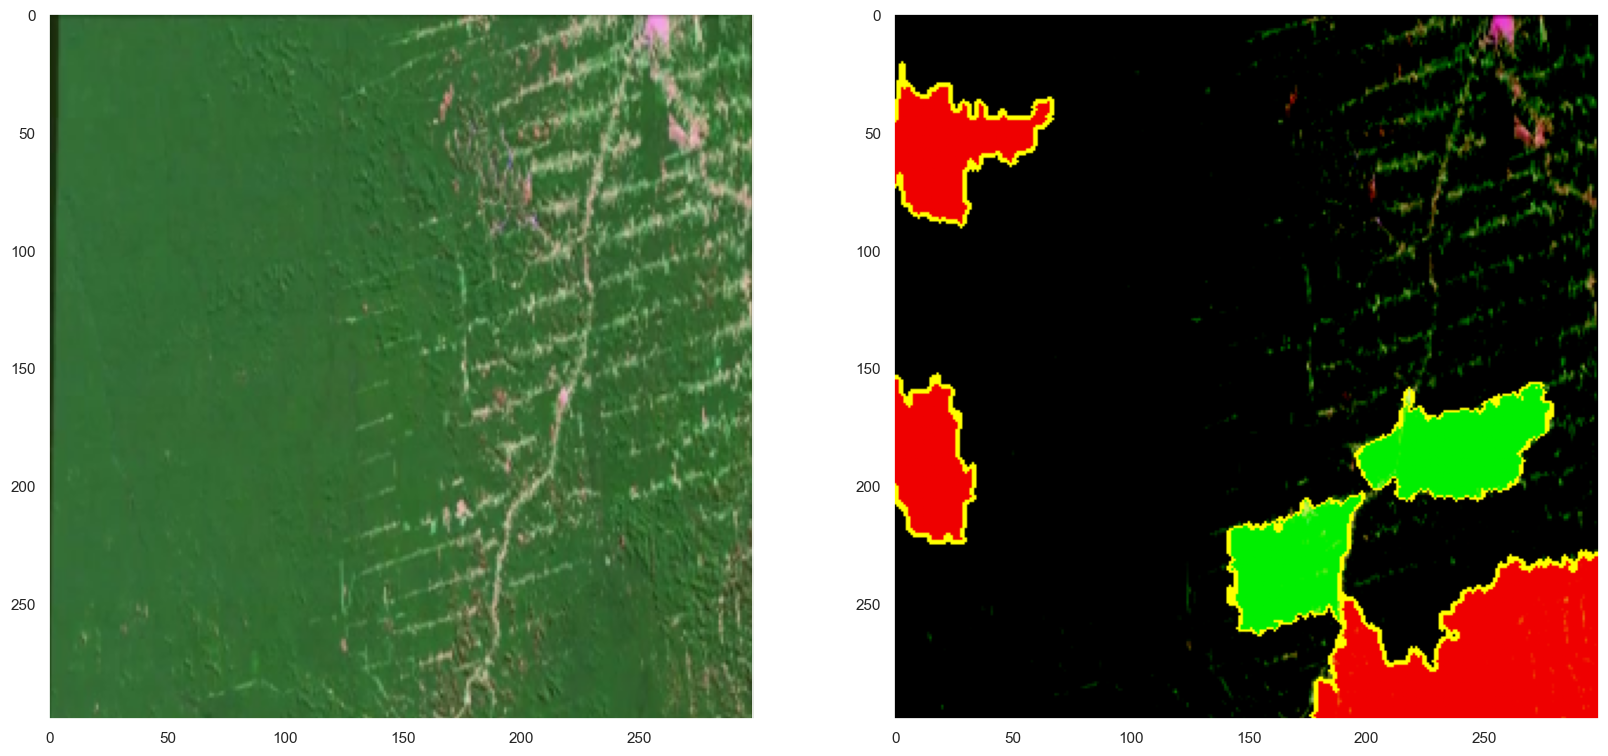

In [76]:
#2450th
explanation2450 = explainer.explain_instance(
         dataset[2449],
         model.predict
)

image, mask = explanation2450.get_image_and_mask(
         explanation2450.top_labels[0],
         positive_only=False,
         hide_rest=False)
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.grid(False)
plt.imshow(cnn_imgs[2449])
plt.subplot(1, 2, 2)
plt.grid(False)
plt.imshow(mark_boundaries(image, mask))

In [77]:
explanation2450.top_labels

[np.int64(0)]

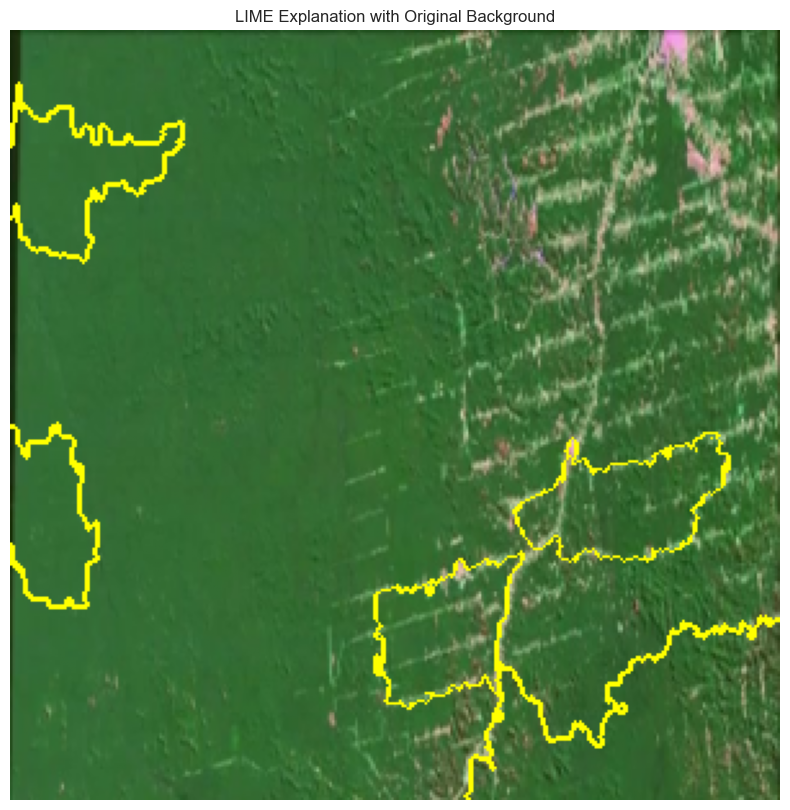

In [78]:
image, mask = explanation2450.get_image_and_mask(
    explanation2450.top_labels[0], 
    positive_only=False, 
    hide_rest=False
)

# Overlay the mask on the original image instead of black background
# Assuming `cnn_imgs[2449]` is the original image (preprocessed for LIME)
original_image = cnn_imgs[2449]  # Replace with your original image array

# Combine the mask and original image
highlighted_image = mark_boundaries(original_image / 255.0, mask)

# Display the image with the mask overlayed
plt.figure(figsize=(10, 10))
plt.imshow(highlighted_image)
plt.axis('off')
plt.title('LIME Explanation with Original Background')
plt.show()

### LIME Explainations for various points of the dataset.

**Images selected are as follows**
1. An image from the normal behaviour :- dataset[100]
2. An image from the normal behavour but close to the anomalous behaviour : dataset[1900]
3. An image from the anomalous behavour but close to the normal behaviour : dataset[2200]
3. An image from the anomalous behaviour: dataset[2450]